## LC Model Search Framework

* Compare 1 season (summer) and 4 temporal steps
* Compare 0 - 1500 training training samples per class in 100 sample increments
* CNN component and RNN components in isolation
* regular CNN+RNN vs conv2dlstm and RNN vs just conv2dLSTM
* Compare to scikit-learn methods using same val and test datasets
* Compare best model across time
    * if major decrease in accuracy then consider training on both 2010 and 2011 data for initial time step
        * consider training on 1999 data to see how it changes the model

In [1]:
#df_cols = experiment_name, time_steps, train_sample_count, model_name, overall_acc, acc_per_class

#list of predictions and labels for each model
#[[preds, labels]...]

In [2]:
import comet_ml
from comet_ml import Experiment
import rasterio
import keras
import random
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Bidirectional
from keras.layers import Conv2D, MaxPooling2D, MaxPooling3D, ConvLSTM2D, TimeDistributed, UpSampling2D, Concatenate, LSTM, concatenate
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD, Adadelta, Adam
from keras import Input
from keras import Model
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import sys
from sklearn.utils import class_weight
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels
import numpy as np

Using TensorFlow backend.


In [3]:
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Code/florence_mapping/utilities.py'>

Assign your specific GPU so we don't overlap

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="0";

Is that GPU and only that GPU visible?

Note that it will always say GPU:0 but you should just see one

In [5]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Ingest Training Labels

Note that these are monster files so be careful how you inspect them, typically you only want to use the `rasterio` windows option

In [6]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')
class_dict = util.indexed_dictionary

Ingest the landsat imagery stacked into yearly seasonal tiles

In [7]:
tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110103', '20110308', '20110730', '20110831', '20111103']
tiles['029011'] = ['20110103', '20110308', '20110730', '20110831', '20111018']
tiles['028011'] = ['20110103', '20110308', '20110831', '20111018', '20111103']

for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

Set up the pandas dataframe for logging everything

In [8]:
import pandas as pd
import seaborn as sns


#cols = experiment, 

### Load pixels from shapefiles

In [9]:
train_gdf = gpd.read_file('../train_buffered_points140520.shp')
train_px = []
for index, row in train_gdf.iterrows():
    train_px.append(((row['row'], row['col']), row['tile_name']))

random.shuffle(train_px)

len(train_px), train_px[0]

(9000, ((2093, 2167), '028012'))

In [48]:
val_gdf = gpd.read_file('../test_buffered_points140520_val.shp')
val_px = []

per_class_count = [0] * 6
total_per_class_count = [0] * 6

for index, row in val_gdf.iterrows():
    if not row['dubious']:
        total_per_class_count[int(row['label'])] = total_per_class_count[int(row['label'])] + 1
        if per_class_count[int(row['label'])] < 125:
            per_class_count[int(row['label'])] = per_class_count[int(row['label'])] + 1
            val_px.append(((row['row'], row['col']), row['tile_name']))
    
random.shuffle(val_px)

len(val_px), val_px[0]

(750, ((963.0, 1038.0), '028012'))

In [49]:
total_per_class_count, per_class_count

([141, 147, 133, 133, 130, 129], [125, 125, 125, 125, 125, 125])

In [50]:
val_gdf.head()

,canopy,col,label,row,tile_name,x,y,manual_val,dubious,reject,geometry
0,0.0,3884.0,0.0,1617.0,028012,1750950.0,1466280.0,0,0,0,POLYGON ((-76.61112678048431 34.64445257944547...
1,0.0,4553.0,0.0,693.0,028011,1771020.0,1644000.0,0,0,0,POLYGON ((-75.98675821109941 36.16139632039837...
2,0.0,1140.0,0.0,1835.0,029011,1818630.0,1609740.0,0,0,0,POLYGON ((-75.54709982307929 35.77251818591635...
3,0.0,3023.0,0.0,3896.0,028011,1725120.0,1547910.0,0,0,0,POLYGON ((-76.70836461104372 35.40562568571118...
4,0.0,989.0,0.0,3414.0,028012,1664100.0,1412370.0,0,0,0,POLYGON ((-77.66217912565303 34.32496740952818...


### Create the RNN

In [13]:
def strangeBlock_v4(input_block, nb_layers, filters):
    x_list = [input_block]
    c_temp = input_block
    for i in range(nb_layers):
        c_l = LSTM(units=filters, activation='elu', return_sequences=True) (c_temp)
        x_list.append(c_l)
        merge = Concatenate()(x_list)
        c_temp = merge
    return c_temp

In [14]:
def make_MLT_dense(in_shape, in_shape_tile, num_classes):
    input_tensor = Input(shape = in_shape, name="rnn_input")
    #single pixel model
    block = strangeBlock_v4(input_tensor, 5, 12)
    block_2 = strangeBlock_v4(block, 3, 20)
    final_block = LSTM(64, activation='softmax', return_sequences=False) (block_2)

    #cnn model
    input_tensor_tile = Input(shape = in_shape_tile, name="tile_input")
    
    
    cnn_layer1 = ConvLSTM2D(64, kernel_size=3, activation='elu', data_format='channels_last', 
                            return_sequences=True)(input_tensor_tile)
    
    first_batch_norm = BatchNormalization()(cnn_layer1)
    
    cnn_layer2 = ConvLSTM2D(64, kernel_size=3, activation='elu', data_format='channels_last', 
                            return_sequences=True)(first_batch_norm)
    
    second_batch_norm = BatchNormalization()(cnn_layer2)
    
    first_pool3D = MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(second_batch_norm)
    
    cnn_layer3 = ConvLSTM2D(64, kernel_size=2, activation='elu', data_format='channels_last', 
                            return_sequences=False)(first_pool3D)
    
    first_pool2D = MaxPooling2D(pool_size=(2, 2), strides=None, padding='same') (cnn_layer3)
    
    third_batch_norm = BatchNormalization()(first_pool2D)
    
    flatten = Flatten()(third_batch_norm)
    
    #concat = concatenate([final_block, flatten])
    
    concat = flatten
    
    denselayer = Dense(64, activation="elu")(concat)
    
    landcover = Dense(num_classes,activation='softmax', name='landcover') (denselayer)
    #canopy = Dense(1, name='canopy') (concat)

    model = Model(inputs=[input_tensor,input_tensor_tile], outputs=[landcover])
    return model

In [15]:
def make_MLT_dense(in_shape, in_shape_tile, num_classes):
    input_tensor = Input(shape = in_shape, name="rnn_input")
    #single pixel model
    block = strangeBlock_v4(input_tensor, 5, 12)
    block_2 = strangeBlock_v4(block, 3, 20)
    final_block = LSTM(64, activation='softmax', return_sequences=False) (block_2)

    #cnn model
    input_tensor_tile = Input(shape = in_shape_tile, name="tile_input")
    
    
    cnn_layer1 = ConvLSTM2D(64, kernel_size=3, activation='elu', data_format='channels_last', 
                            return_sequences=True)(input_tensor_tile)
    
    first_batch_norm = BatchNormalization()(cnn_layer1)
    
    cnn_layer2 = ConvLSTM2D(64, kernel_size=3, activation='elu', data_format='channels_last', 
                            return_sequences=True)(first_batch_norm)
    
    second_batch_norm = BatchNormalization()(cnn_layer2)
    
    first_pool3D = MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(second_batch_norm)
    
    cnn_layer3 = ConvLSTM2D(64, kernel_size=2, activation='elu', data_format='channels_last', 
                            return_sequences=True)(first_pool3D)
    
    third_batch_norm = BatchNormalization()(cnn_layer3)
    
    #first_pool2D = MaxPooling2D(pool_size=(2, 2), strides=None, padding='same') (third_batch_norm)
    #second_pool3D = MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(third_batch_norm)
    
    flatten = Flatten()(third_batch_norm)
    
    #concat = concatenate([final_block, flatten])    
    denselayer = Dense(64, activation="elu")(flatten)
    
    landcover = Dense(num_classes,activation='softmax', name='landcover') (denselayer)
    #canopy = Dense(1, name='canopy') (concat)

    model = Model(inputs=[input_tensor,input_tensor_tile], outputs=[landcover])
    return model

In [16]:
def make_MLT_dense(in_shape, in_shape_tile, num_classes):
    input_tensor = Input(shape = in_shape, name="rnn_input")
    #single pixel model
    block = strangeBlock_v4(input_tensor, 5, 12)
    block_2 = strangeBlock_v4(block, 3, 20)
    final_block = LSTM(64, activation='softmax', return_sequences=False) (block_2)

    #cnn model
    input_tensor_tile = Input(shape = in_shape_tile, name="tile_input")
    cnn_layer1 = ConvLSTM2D(64, kernel_size=3, activation='elu', return_sequences=True, data_format='channels_last')(input_tensor_tile)
    first_batch_norm = BatchNormalization()(cnn_layer1)
    cnn_layer2 = ConvLSTM2D(64, kernel_size=3, activation='elu', return_sequences=True, data_format='channels_last') (first_batch_norm)
    second_batch_norm = BatchNormalization()(cnn_layer2)
    maxpool = MaxPooling3D(pool_size=(1, 2, 2), strides=None, padding='same') (second_batch_norm)
    cnn_layer3 = ConvLSTM2D(64, kernel_size=2, activation='elu', return_sequences=False, data_format='channels_last') (second_batch_norm)
    flatten = Flatten()(cnn_layer3)
    #concat = concatenate([final_block, flatten])
    
    denselayer = Dense(64, activation="relu")(flatten)
    
    landcover = Dense(num_classes,activation='softmax', name='landcover') (denselayer)
    #canopy = Dense(1, name='canopy') (concat)

    model = Model(inputs=[input_tensor,input_tensor_tile], outputs=[landcover])
    return model

In [17]:
def make_MLT_dense(in_shape, in_shape_tile, num_classes):
    input_tensor = Input(shape = in_shape, name="rnn_input")
    #single pixel model
    block = strangeBlock_v4(input_tensor, 5, 12)
    block_2 = strangeBlock_v4(block, 3, 20)
    final_block = LSTM(64, activation='softmax', return_sequences=False) (block_2)

    #cnn model
    input_tensor_tile = Input(shape = in_shape_tile, name="tile_input")
    cnn_layer1 = ConvLSTM2D(64, kernel_size=3, activation='elu', return_sequences=True)(input_tensor_tile)
    # batch norm
    cnn_layer2 = ConvLSTM2D(64, kernel_size=3, activation='elu', return_sequences=False) (cnn_layer1)
    maxpool = MaxPooling2D(pool_size=(2, 2), strides=None, padding='same') (cnn_layer2)
    flatten = Flatten()(maxpool)
    concat = concatenate([final_block, flatten])
    
    denselayer = Dense(64, activation="elu")(concat)
    
    landcover = Dense(num_classes,activation='softmax', name='landcover') (denselayer)
    #canopy = Dense(1, name='canopy') (concat)

    model = Model(inputs=[input_tensor,input_tensor_tile], outputs=[landcover])
    return model

Start the experiments here:

In [18]:
exp_name = 'full_classic_test_validated'

In [19]:
experiment = Experiment(api_key="rMFbl2RlGxNuyyL37dE7qPSfE",
                        project_name="chronos", workspace="clifgray")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/clifgray/chronos/bcf5e81695ef4bf592c3d1c2212157fd



In [20]:
experiment.add_tag(exp_name)

In [21]:
tile_size = 13
tile_list = ['028012', '029011', '028011']
class_count = len(class_dict)
epochs = 60
batch_size = 25
clean_pixels_count = 4000000
max_count_per_class = 1500
steps_division_factor = 10

In [22]:
model = make_MLT_dense((len(tiles['028012']),7),(len(tiles['028012']),tile_size,tile_size,7), class_count)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rnn_input (InputLayer)          (None, 5, 7)         0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 5, 12)        960         rnn_input[0][0]                  
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 5, 19)        0           rnn_input[0][0]                  
                                                                 lstm_1[0][0]                     
__________________________________________________________________________________________________
lstm_2 (LSTM)       

#### Train the Model

In [23]:
filepath = 'mlt_dense_model_pcg.hdf5' #your filepath here
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

In [24]:
model.compile(optimizer=Adam(), loss={'landcover':'categorical_crossentropy'}, metrics={'landcover':['accuracy']}, loss_weights={"landcover":1})

In [25]:
util.class_to_index

{11: 0,
 21: 3,
 22: 1,
 23: 1,
 24: 1,
 31: 4,
 41: 2,
 42: 2,
 43: 2,
 52: 2,
 71: 3,
 81: 3,
 82: 3,
 90: 2,
 95: 5}

In [26]:
history = model.fit_generator(generator=tile_gen.tile_generator(train_px, batch_size, flatten=True, canopy=True), 
                steps_per_epoch=len(train_px) // batch_size // steps_division_factor, epochs=epochs, verbose=1,
                validation_data=tile_gen.tile_generator(val_px, batch_size, flatten=True, canopy=True),
                validation_steps=len(val_px) // batch_size,
                callbacks=callbacks_list) 

Instructions for updating:
Use tf.cast instead.


COMET INFO: Ignoring automatic log_parameter('do_validation') because 'keras:do_validation' is in COMET_LOGGING_PARAMETERS_IGNORE
COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/60
 1/36 [..............................] - ETA: 4:35 - loss: 1.8992 - acc: 0.1600

COMET INFO: Ignoring automatic log_metric('batch_size') because 'keras:batch_size' is in COMET_LOGGING_METRICS_IGNORE
COMET INFO: Ignoring automatic log_metric('batch_batch') because 'keras:batch_batch' is in COMET_LOGGING_METRICS_IGNORE


36/36 [==============================] - 16s 431ms/step - loss: 0.8209 - acc: 0.7011 - val_loss: 0.4049 - val_acc: 0.8463

Epoch 00001: val_acc improved from -inf to 0.84625, saving model to mlt_dense_model_pcg.hdf5
Epoch 2/60
36/36 [==============================] - 6s 180ms/step - loss: 0.4496 - acc: 0.8522 - val_loss: 0.3642 - val_acc: 0.8537

Epoch 00002: val_acc improved from 0.84625 to 0.85375, saving model to mlt_dense_model_pcg.hdf5
Epoch 3/60
36/36 [==============================] - 7s 185ms/step - loss: 0.4277 - acc: 0.8422 - val_loss: 0.2788 - val_acc: 0.9037

Epoch 00003: val_acc improved from 0.85375 to 0.90375, saving model to mlt_dense_model_pcg.hdf5
Epoch 4/60
36/36 [==============================] - 6s 176ms/step - loss: 0.4267 - acc: 0.8667 - val_loss: 0.1987 - val_acc: 0.9350

Epoch 00004: val_acc improved from 0.90375 to 0.93500, saving model to mlt_dense_model_pcg.hdf5
Epoch 5/60
36/36 [==============================] - 6s 176ms/step - loss: 0.3456 - acc: 0.8656 - 

36/36 [==============================] - 6s 174ms/step - loss: 0.1327 - acc: 0.9578 - val_loss: 0.0803 - val_acc: 0.9750

Epoch 00043: val_acc did not improve from 0.97625
Epoch 44/60
36/36 [==============================] - 6s 176ms/step - loss: 0.1432 - acc: 0.9511 - val_loss: 0.1050 - val_acc: 0.9600

Epoch 00044: val_acc did not improve from 0.97625
Epoch 45/60
36/36 [==============================] - 6s 174ms/step - loss: 0.1155 - acc: 0.9611 - val_loss: 0.1012 - val_acc: 0.9637

Epoch 00045: val_acc did not improve from 0.97625
Epoch 46/60
36/36 [==============================] - 6s 176ms/step - loss: 0.0780 - acc: 0.9756 - val_loss: 0.1171 - val_acc: 0.9512

Epoch 00046: val_acc did not improve from 0.97625
Epoch 47/60
36/36 [==============================] - 6s 174ms/step - loss: 0.1414 - acc: 0.9511 - val_loss: 0.1191 - val_acc: 0.9625

Epoch 00047: val_acc did not improve from 0.97625
Epoch 48/60
36/36 [==============================] - 6s 177ms/step - loss: 0.1399 - acc: 0.9

dict_keys(['loss', 'val_acc', 'val_loss', 'acc'])


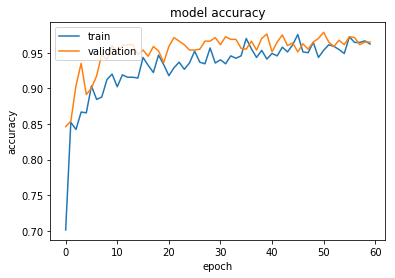

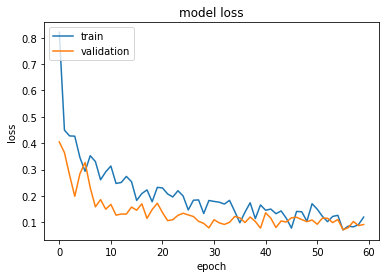

In [27]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [28]:
model = keras.models.load_model('mlt_dense_model_pcg.hdf5')

# Evaluate model

In [51]:
import datetime
print(datetime.datetime.now())
predictions = model.predict_generator(generator = tile_gen.tile_generator(val_px, batch_size=1, flatten=True, canopy=True), steps=len(val_px) // 1, verbose=1)
print(datetime.datetime.now())
eval_generator = tile_gen.tile_generator(val_px, batch_size=1, flatten=True, canopy=True)

2020-05-15 16:24:20.429074
750/750 [==============================] - 27s 36ms/step
2020-05-15 16:24:47.257654


In [30]:
450 * 60 *60 * 24

38880000

In [52]:
predictions.shape

(750, 6)

In [53]:
lc_predictions = predictions

In [54]:
lc_lab = np.empty(lc_predictions.shape[0])
#canopy_true = np.empty(canopy_pred.shape)
count = 0
while count < len(lc_predictions):
        image_b, label_b = next(eval_generator)
        #label_b = np.argmax(label_b, axis=-1)
        label_lc = np.argmax(label_b['landcover'], axis=-1)
        #canopy_true[count] = label_b['canopy']
        lc_lab[count] = label_lc
        count += 1
label_index = lc_lab.reshape(len(val_px)*1*1)
pred_index = np.argmax(lc_predictions, axis=-1).reshape(len(val_px)*1*1)

Accuracy is 0.9773333333333334
per_class_acc 1.0
per_class_acc 1.0
per_class_acc 0.992
per_class_acc 0.952
per_class_acc 0.944
per_class_acc 0.976


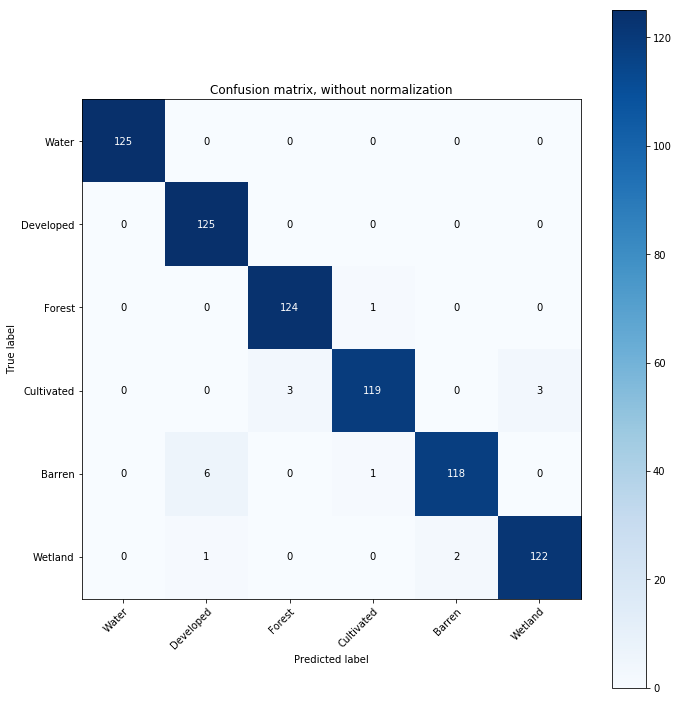

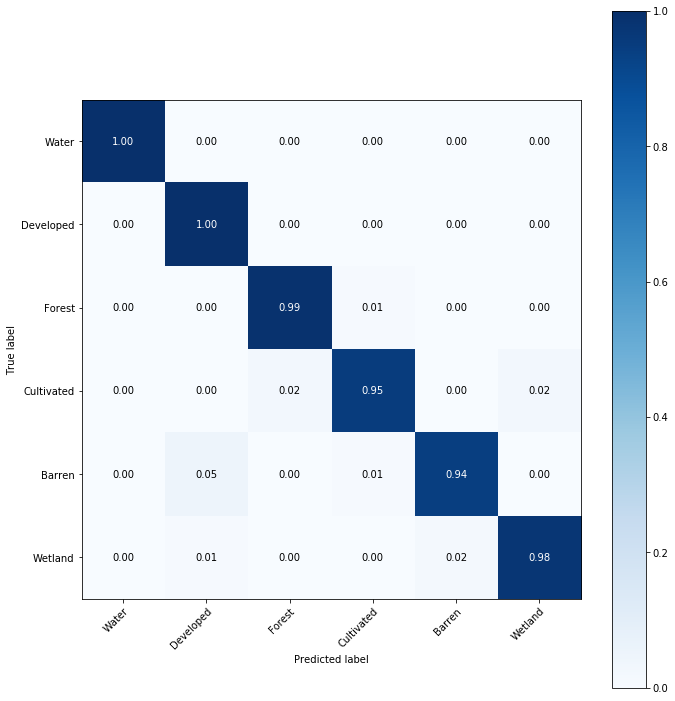

In [55]:
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(class_dict)),
                      class_dict=class_dict)
experiment.log_figure(figure=plt, figure_name="unnorm_conf_matrix")
# Plot normalized confusion matrix
util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(class_dict)),
                      class_dict=class_dict,
                      normalize=True,
                          title=" ")
experiment.log_figure(figure=plt, figure_name="norm_conf_matrix")
count = 0
per_class_acc = [0] * 6
for i in range(len(label_index)):
    if(label_index[i] == pred_index[i]):
        per_class_acc[int(label_index[i])] = per_class_acc[int(label_index[i])] + 1
        count+=1

val_accuracy=count/len(label_index)
class_acc_dict = {}
print("Accuracy is",val_accuracy)
for idx, class_correct in enumerate(per_class_acc):
    class_acc_dict[class_dict[idx]] = round(class_correct/(int(len(label_index)/class_count)),4)
    print('per_class_acc', class_correct/(per_class_count[idx]))

In [ ]:
class_dict, class_acc_dict

Calculate the accuracy per class
Calculate overall accuracy
Add training samples
add epochs
add tile size

In [ ]:
#pred_df = pd.DataFrame({'lc_pred': pred_index,
#                        'lc_true': label_index})

In [ ]:
params = {
    "landsat_tiles":tiles,
    "cnn_tile_size":tile_size,
    "class_dict":class_dict,
    "batch_size":batch_size,
    #"clean_pixels_counts":clean_pixels_count,
    #"max_count_per_class": max_count_per_class,
    #"class_count_dict":['{} : {}'.format(k,v) for k,v in class_count_dict.items()],
    "steps_division_factor":steps_division_factor,
    #"canopy_validation_r2":validation_r2,
    "lc_validation_acc":val_accuracy
}
experiment.log_parameters(params)

In [ ]:
experiment.end()